In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium.plugins
import folium
import requests
import json
import datetime
import plotly.graph_objs as go
import plotly.express as px
import ipywidgets as widgets
import sklearn.linear_model as sk
import sklearn.model_selection as sm

# Custom module
import API_Access as api


In [ ]:
# TODO Entfernen für Abgabe
import importlib
importlib.reload(api)


 ### Aufgabe 1 (Messstationen, Datenakquise, Semistrukturierte Daten, Geovisualisierung)

 #### a)

 Zu Beginn wird sich ein Überblick über die API des Umweltbudesamtes verschaffen.<br/>
Die API bietet eine Schnittstelle an, um Meta-Daten aller bundesweiten Messtationen zu erhalten.

In [2]:
# API zum Stand 01.01.2020 abfragen
df_stations = api.GetMetaData_Stations_All(
    date_from="2020-01-01", date_to="2020-01-01")
df_stations


,Code,Name,Location,Code_Name,Construction_Date,Deconstruction_Date,Longtitude,Latitude,Network_ID,Settings_ID,Type_ID,Network_Code,Network_Name,Settings_Long,Settings_Short,Type,Street_Name,Street_Number,ZIP_Code
ID,,,,,,,,,,,,,,,,,,,
7,DEBB007,Elsterwerda,Elsterwerda,ELBA,1992-09-01,NaT,13.5268,51.4627,4.0,2.0,1.0,BB,Brandenburg,suburban area,suburban,background,Lauchhammerstr.,,04910
21,DEBB021,Potsdam-Zentrum,Potsdam,PDBA,2009-04-15,NaT,13.0599,52.4014,4.0,1.0,1.0,BB,Brandenburg,urban area,urban,background,Am Bassinplatz,,14467
28,DEBB029,Schwedt (Oder),Schwedt/Oder,SWHE,1993-04-06,NaT,14.2851,53.0643,4.0,2.0,2.0,BB,Brandenburg,suburban area,suburban,industry,Helbigstr.,,16303
31,DEBB032,Eisenhüttenstadt,Eisenhüttenstadt,EHST,1993-04-20,NaT,14.6382,52.1463,4.0,2.0,2.0,BB,Brandenburg,suburban area,suburban,industry,Karl-Marx-Str.,35,15890
42,DEBB044,"Cottbus, Bahnhofstr.",Cottbus,COBA,2012-09-25,NaT,14.3280,51.7566,4.0,1.0,3.0,BB,Brandenburg,urban area,urban,traffic,Bahnhofstr.,55,03046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1973,DEUB029,Schmücke,Gehlberg,,1978-07-01,NaT,10.7695,50.6541,17.0,3.0,1.0,UB,UBA,rural area,rural,background,Schmücke,,98559
1974,DEUB030,Neuglobsow,Neuglobsow,,1969-01-01,NaT,13.0317,53.1413,17.0,5.0,1.0,UB,UBA,rural regional,rural,background,Zur alten Fischerhütte,1,16775
1990,DEUB046,Forellenbach,Spiegelau,,2000-01-01,NaT,13.4206,48.9476,17.0,4.0,1.0,UB,UBA,rural secluded,rural,background,,,94518


 Für die spätere Verwendung werden die Stationsdaten in eine in eine CSV-Datei exportiert.

In [ ]:
df_stations.to_csv("stations_2020.csv")
df_stations = pd.read_csv("stations_2020.csv", index_col="ID")

 #### b)
 Wenn die Spalte Deconstruction_Date keine Wert enthält, ist anzunehmen, dass die Station noch in Betrieb ist.

In [4]:
len(df_stations.loc[df_stations["Deconstruction_Date"].isnull()])


431

 Nach dieser Annahmen sind zum Stand 01.01.2020 bundesweit 431 aktive Stationen zu verzeichnen.

 #### c)

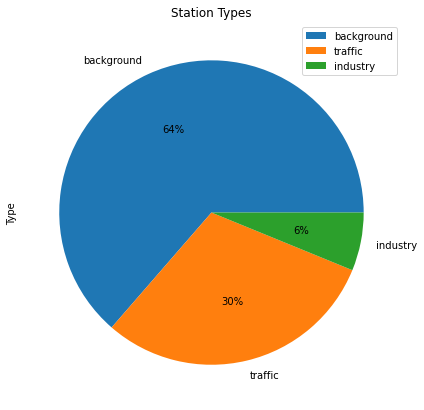

In [12]:
df_stations['Type'].value_counts().plot.pie(figsize=(7, 7), title="Station Types", legend=True, autopct='%1.0f%%')

Das Diagramm zeigt die Verteilung Stations Typen, welche für die spätere Analyse von Bedeutung sind.

 #### d)

Die interaktive Karte, die durch Folium erstellt wird, zeigt die geographische Verteilung der Stationen in Deutschland.<br/>
Der Name der Station wird beim Klicken auf die Kreismakierungen angezeigt.<br/>
Die Stationenstypen werden farblich unterschieden.

In [15]:
colors = {"industry": "yellow", "traffic": "red", "background": "green"}

m = folium.Map()

for i in range(len(df_stations)):
    folium.Circle(
        location=df_stations[['Latitude', 'Longtitude']].iloc[i],
        popup=df_stations['Name'].iloc[i],
        radius=30,
        color=colors[df_stations['Type'].iloc[i]],
    ).add_to(m)

# Optimalen standard Zoom-Faktor berechnen
sw = df_stations[['Latitude', 'Longtitude']].min().values.tolist()
ne = df_stations[['Latitude', 'Longtitude']].max().values.tolist()
m.fit_bounds([sw, ne])

m

 Grundsätzlich erkennt man eine breitfläche Verteilung der Stationen über ganz Deutschland, wobei<br/>
 urbane Gebiete dennoch eine höhere Dichte an Stationen aufweisen als vergleichsweise ländliche Regionen.<br/> 
 Die Region Düsseldorft besitzt visuell die höchste Stationsdichte, gefolgt von Berlin, Hamburg und Frankfurt.<br/> 
 An dieser Stelle auch schon auffällig ist, das Bayern keine Station vom Typ 'industry" verweisen kann.

 #### e)

  Für alle nachfolgenden Analysen werden werden nur die Daten der Stationen aus Bayern verwendet.

In [ ]:
stations_BY = df_stations[df_stations['Network_Name'] == "Bavaria"]

 ### Aufgabe 2 (NO2-Daten, Datenvorbereitung, Datenqualität)

 #### a)

In [ ]:
# stations_data_dict = dict()
# for id in stations_BY.index:
#     response = requests.get("https://www.umweltbundesamt.de/api/air_data/v2/measures/json", params={
#                             "date_from": "2016-01-01", "time_from": "1", "date_to": "2019-12-31", "time_to": "24", "station": str(id), "component": "5", "scope": "2"})
#     json_data = json.loads(response.text)
#     stations_data_dict[id] = json_data['data']
#     if(response.status_code == 200):
#         print(str(id) + ": Abfrage fertig")
#     else:
#         break

# # %% # TODO DEPRICATED
# list_to_create = []
# for station_id in stations_data_dict:
#     for station_data in stations_data_dict[station_id]:
#         measurements_for_id = stations_data_dict[station_id][station_data].values(
#         )
#         for data_point in measurements_for_id:
#             datetime = data_point[3]
#             no2_value = data_point[2]
#             list_to_create.append([station_id, datetime, no2_value])
# df_data_no2 = pd.DataFrame(list_to_create, columns=[
#     "STATION_ID", "DT", "NO2"])
# df_data_no2.index.name = 'dp_id'
# df_data_no2 = df_data_no2.replace(
#     to_replace='24:00:00', value="00:00:00", regex=True)


 Im Folgenden wird die API für jede bayrische Station nach deren stündlichen Mittelwerten der NO2 Messungen zwischen dem 01.01.2016 und 31.12.2019 abfragt.
 Ein eigens dafür erstelltes Wrapper-Modul tätigt die API abfragen und überführt die erhaltenen Daten in ei Dataframe 'station_data'.
 Stationen, für die es keine Daten gibt, erhalten für jeden möglichen Messzeitpunkt im angegebenen Zeitraum jeweils einen NaN-Wert.
 Die Stationsdaten werden dann zu einem Dateframe 'df_data_no2' konkatiniert, welches die Grundlage in den nachfolgenden Analyse verwendet wird.

In [ ]:
df_data_no2 = pd.DataFrame()
missing_data_stations = []
for station_id in stations_BY.index:
    try:
        station_data = api.GetMeasurements_MeanPerHour_SingleComponent(
            station_id=str(station_id),
            component=api.ComponentEnum.NO2,
            date_from="2016-01-01",
            date_to="2019-12-31")

        # Append to final df
        df_data_no2 = pd.concat([df_data_no2, station_data], ignore_index=True)

    except:
        missing_data_stations.append(station_id)

df_data_no2
# returns 1814952 rows # TODO MERKER ENTFERNEN
# and 1557272  no2 value count()
# Nach Anpassung 1604568 rows

 Bayrische Stationen die keine Daten im Betrachtungszeitraum liefern

In [ ]:
stations_BY[stations_BY.index.isin(missing_data_stations)]
# # %% [markdown]

 Anschließend wird das Dateframe für die Analyse vorbereitet:
 #### b)

 Hier wird die Spalte NO2 in das nummerische Datenformat float überführt

In [ ]:
df_data_no2["NO2"] = pd.to_numeric(df_data_no2["NO2"], errors="coerce")


 Die Spalte 'DT' enthält ein valides DateTime-Format. Somit ist die Umwandlung durch ein simples pd.to_datetime erledigt.

In [ ]:
df_data_no2["DT"] = pd.to_datetime(df_data_no2["DT"], errors="coerce")

 #### c)

Hier werden alle Datenpunkte die keinen Wert in der Splate NO2 haben aus dem Datenframe df_data_no2 entfernt. Desweiteren wird die Anzahl der entfernten Datenpunkte angegeben.

In [ ]:
df_measurements_nanCleaned = df_data_no2.dropna(
    axis=0, how="any", subset=["NO2"])

print("Es wurden " + str(len(df_data_no2) - len(df_measurements_nanCleaned)) +
      " Datenpunkte entfernt bei denen der NO2-Messwert gefehlt hat.")

df_data_no2 = df_measurements_nanCleaned

# Es wurden 222693 gedroppt #TODO Merker entfernen
# Nach Anpassung: 12309 entfernt aber nachwievor:
# df_measurements_nanCleaned hat 1592259 Zeilen
# TODO Station 490 ist ganz rausgefallen

 #### d)

Hier werden nun alle Sationen aus dem Datenframe entfernt die für weniger als 95% der Datenpunkte keinen NO2 Wert haben. Da jedoch schon alle Datenpunkte, für die kein NO2 Wert vorhanden war entfernt wurden, wird dies mithilfe der Zeitspanne ermittelt, welche sich über den gesamten Beobachtungszeitraum erstreckt (01.01.2016-31.12.2019), ermittelt.

In [ ]:
# Mithilfe der Zeitspanne wird ermittelt, wie viele Datenpunkte eigentlich vorhanden sein sollten
expected_number_of_datapoints = (
    df_data_no2["DT"].max() - df_data_no2["DT"].min()).days * 24

# Anschließend kann man alle Stationen entfernen, die nur weniger als 95% der möglichen Daten liefern
treshold_filter = df_data_no2.groupby("STATION_ID").filter(
    lambda grp: grp["DT"].count() / expected_number_of_datapoints < 0.95
)
df_data_no2.drop(treshold_filter.index, inplace=True)
# TODO Station 511 und 513 sind rausgefallen


 #### e)

Es wird nun anhand der Länge ermittelt wie viele Sationen noch vorhanden sind.

In [ ]:
len(df_data_no2["STATION_ID"].unique())

 #### f)

Mithilfe das Datenframe stations_BY werden die Namen der Stationen ausgegeben, die entfernt wurden.

In [ ]:
# Folgende Stationen sind aus dem Dataframe gefallen
# TODO Beheben
stations_BY.loc[treshold_filter][["Name"]]


 ### Aufgabe 3 (Explorative Datenanalyse)

 #### a)

Hier werden alle Datenpunkte ausgewählt, die den maximal Wert in der Spalte NO2 haben. Es werdem danach die Id(s), der Name(n), der/die Zeitstempel und der/die Messwert(e) der Station(en) ausgegeben. 

In [ ]:
# MaxRow_ID, MaxRow_DT, MaxRow_NO2 = df_data_no2.iloc[df_data_no2["NO2"].idxmax(
# )][["STATION_ID", "DT", "NO2"]]
max_row = df_data_no2.loc[df_data_no2["NO2"] == df_data_no2["NO2"].max()]
# print("Der höchste NO2 Ein-Stunden-Mittelwert betrug " + max_row['NO2'] + "."
#       "\nEr wurde an Station " + max_row['STATION_ID'] + " '" + df_stations.loc[max_row['STATION_ID']]["Name"] + "' am " + max_row['DT'] + " gemessen.")
max_row.merge(df_stations.loc[max_row['STATION_ID']]
              [["Name"]], left_on="STATION_ID", right_index=True)



 #### b)

Die Datenen werden nach Tagen gruppiert und Mittelwerte über die Tage gebildet. Der Tag mit der Höchsten durchsnittlichen ein-Stunden-Konzentration von NO2 war der 23.01.2017 mit knapp 75.56 μg/m3.

In [3]:
df_data_no2[['Date', "NO2"]].groupby(df_data_no2["DT"].dt.date).mean(
).sort_values(by="NO2", ascending=False).head(1)

NameError: name 'df_data_no2' is not defined

 #### c)

Es sollen die 10 höchsten NO2 Konzentrationen der Sation in der Nikolaistraße in Weiden ausgegben werden. Die Daten zu dieser Station werden mit werden mithilfe der Datenframes df_stations und df_data_no2 aggregiert.

In [ ]:
id_nicolaistreet = df_stations.loc[df_stations["Name"] ==
                                   "Weiden i.d.OPf./Nikolaistraße"].index[0]
df_measurements_nico = df_data_no2.loc[df_data_no2["STATION_ID"]
                                       == id_nicolaistreet]
df_measurements_nico.sort_values(by="NO2", ascending=False, inplace=True)
# print(df_measurements_nico.iloc[: 10].to_string(
#     index=False, columns=["DT", "NO2"]))
df_measurements_nico.iloc[: 10][["DT", "NO2"]]

 #### d)

Als erster Schritt werden die Datenpunkte nach ihren Jahren gruppiert

In [ ]:
# Gruppierung nur nach Year
df_yearMean = df_data_no2.groupby(df_data_no2["DT"].dt.year).mean()
df_yearMean

# Gruppierung nur nach Year und Type, dazu ist merge notwendig

Es wird ein Hilfsdatenframe angelegt, welches die Datenpunkte mit den zugehörigen Sationstypen enthält. Dieses Datenframe wird danach Nach Jahr und Typ gruppiert (Obere Zelle NÖTIG ???) und danach as Balkendiagramm angezeigt, wobei die X-Achse die Zeit in Jahren enthält und die Y-Achse die durchschnittliche NO2 Konzentration. Desweitern sind pro Jahr zwei Balken zu erkennen, wobei jeder Balken einen Stationstyp repräsentiert.

In [4]:
df_merge = df_data_no2.merge(
    df_stations[["Type"]], how="left", left_on="STATION_ID", right_index=True)

df_YearTypeMean = df_merge.groupby(
    [df_merge["DT"].dt.year, "Type"]).mean()[["NO2"]]
df_YearTypeMean

# Diagramm zeigt Mittelwert über Jahre gruppiert nach Typ
df_YearTypeMean.unstack().plot(kind="bar")

NameError: name 'df_data_no2' is not defined

 ### Aufgabe 4 (Verletzung der zulässigen NO2-Grenzwerte)

 #### a)

Es sollen alle Stationen gefunden werden, bei denen eine Verletzung der stündlichen NO2 Grenzwerte vorliegt. Das Datenframe wird entsprechen gefiltert und nach Stations-Id's gruppiert. Auffällig ist, dass keine Sationen möfter als 18 mal im Jahr diesen Grenzwert überschreiten. 

In [ ]:
# Alle Überschreitungen holen
violating_datapoints = df_data_no2[df_data_no2["NO2"] > 200]

# Die Anzahl pro Station auswerten
violations_per_station = violating_datapoints.groupby("STATION_ID").count()[
    ["NO2"]].rename(columns={"NO2": "NO2_limit_violations"})

violations_per_station


Darunterliegende Zelle NÖTIG???

In [ ]:
violating_datapoints.groupby(
    ["STATION_ID", violating_datapoints["DT"].dt.year]).count()[["NO2"]]
# Todo Fragen ob wirklich keine überschreiten



 #### b)

Nun sollen jahrliche Versößte gegen die durschnittliche ein-Stunden-Konzentration von NO2 ermittelt werden. Dazu wird das Datenframe passent gruppiert und der Mittelwert gebildet.

In [5]:
violations_data_points_yearly = df_data_no2.groupby(
    by=["STATION_ID", df_data_no2["DT"].dt.year]).mean()["NO2"]

violations_data_points_yearly[violations_data_points_yearly > 40]

NameError: name 'df_data_no2' is not defined

 ### Aufgabe 5 (Visualisierung)

 #### a) (Missing????)

 #### b)

In [ ]:
SEASONS = np.array(['Winter', 'Spring', 'Summer', 'Autumn'])
month = np.arange(12) + 1
season = SEASONS[(month // 3) % 4]


def month_to_season(month_int):
    return season[month_int - 1]



In [ ]:
df_data_no2["Season"] = df_data_no2["DT"].map(
    lambda dt: month_to_season(dt.month))


In [ ]:
# df_measurements.groupby(month_to_season(df_measurements["DT"].dt.month)).mean()[["NO2"]]

df_mean_per_season = df_data_no2.groupby(
    [
        df_data_no2["DT"].dt.year,
        month_to_season(df_data_no2["DT"].dt.month)
    ]
).mean()[["NO2"]]


In [ ]:
# Alternative zu meinem iloc
# df_mean_per_season.unstack().loc[:, (slice(None), "Spring")].values
df_mean_per_season.rename_axis(['Year', 'Season'], inplace=True)


In [ ]:
x_years = df_mean_per_season.index.get_level_values(level="Year").unique()

mean_yearly_values = []
for year in x_years:
    mean_yearly_values.append(df_mean_per_season.loc[year].values.mean())


trace1 = go.Scatter(
    x=x_years,
    y=df_mean_per_season.iloc[df_mean_per_season.index.isin(
        ["Spring"], level='Season')]["NO2"],
    mode="lines",
    name="Spring NO2 Averages"
)
trace2 = go.Scatter(
    x=x_years,
    y=df_mean_per_season.iloc[df_mean_per_season.index.isin(
        ["Autumn"], level='Season')]["NO2"],
    mode="lines",
    name="Autumn NO2 Averages"
)
trace3 = go.Scatter(
    x=x_years,
    y=df_mean_per_season.iloc[df_mean_per_season.index.isin(
        ["Summer"], level='Season')]["NO2"],
    mode="lines",
    name="Summer NO2 Averages"
)
trace4 = go.Scatter(
    x=x_years,
    y=df_mean_per_season.iloc[df_mean_per_season.index.isin(
        ["Winter"], level='Season')]["NO2"],
    mode="lines",
    name="Winter NO2 Averages"
)
# TODO Explain additional trace
trace5 = go.Scatter(
    x=x_years,
    y=mean_yearly_values,
    mode="lines",
    name="Average yearly NO2 Concentration"
)

layout = go.Layout(
    template="plotly_dark",
    title=go.layout.Title(
        text='<b>Jahreszeitlicher Verlauf der NO2 Konzentration</b>',
        font=dict(color='royalblue')
    ),
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text='Jahre',
            font=dict(color='lightblue')
        )
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text='Konzentration',
            font=dict(color='lightblue')
        )
    )
)

data = [trace1, trace2, trace3, trace4, trace5]
fig = go.Figure(data=data, layout=layout)

fig.show()


Klar zu erkennen ist, dass die NO2 Konzentration im Winter signifikant höher ist all alle anderen Jahreszeiten.

 #### c)

In [ ]:
df_mean_per_day = df_data_no2.groupby(
    df_data_no2["DT"].dt.date).agg({"NO2": "mean"})

In [ ]:
fig = px.line(
    df_mean_per_day,
    x=df_mean_per_day.index,
    y=df_mean_per_day["NO2"],
    title='Mean NO2 per day')
fig.show()

# endregion


 ### Aufgabe 6  (Interaktives Diagramm)

 #### a)

In [ ]:
df_merge = df_data_no2.merge(
    df_stations[['Type']], how='left', left_on='STATION_ID', right_index=True)

In [ ]:
df_data = df_merge.groupby(
    [
        df_merge['Type'],
        df_merge['DT'].dt.strftime('%A'),
        df_merge['DT'].dt.strftime('%X'),
    ]
).mean()[['NO2']]


df_data.rename_axis(['Type', 'Weekday', 'Hour'], inplace=True)
df_data


In [ ]:

data = [go.Bar(
    x=df_data.index.get_level_values('Hour').unique(),
    y=df_data['NO2'],
)]

layout = go.Layout(
    template="plotly_dark",
    title=go.layout.Title(
        text='Daily chart of mean NO2 measurements of bavarian stations',
        font=dict(
            size=24,
            color='#4863c7'
        )
    ),
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text='Hour',
            font=dict(
                size=18,
                color='green'
            )
        )
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text='NO2',
            font=dict(
                size=18,
                color='green'
            )
        ),
        range=[0, 45]
    ),
    hovermode='closest'
)

fig = go.FigureWidget(data=data, layout=layout)

radio_type = widgets.RadioButtons(
    options=list(df_data.index.get_level_values('Type').unique()) + ['all'],
    description='Type of Stations'
)
radio_day = widgets.RadioButtons(
    options=list(df_data.index.get_level_values('Weekday').unique()) + ['All'],
    description='Days of Weeks'
)


def update_graph(change):
    chosen_type = radio_type.value
    chosen_day = radio_day.value
    if chosen_type == 'all' and chosen_day == 'All':
        df_diagramm = df_data.unstack().mean()
    elif chosen_type == 'all':
        df_diagramm = df_data.iloc[df_data.index.isin(
            [chosen_day], level='Weekday')].unstack().mean()
    elif chosen_day == 'All':
        df_diagramm = df_data.loc[chosen_type]
    else:
        df_diagramm = df_data.loc[chosen_type, chosen_day]

    with fig.batch_update():
        fig.layout.xaxis.autorange = False
        fig.layout.yaxis.autorange = False
        fig.data[0].y = df_diagramm['NO2']
        fig.data[0].text = df_diagramm['NO2']

# TODO Cleanup Text


# Verknüpfung der Callback-Funktion mit dem Widget
radio_type.observe(update_graph, names='value')
radio_day.observe(update_graph, names='value')

radio_buttons = widgets.HBox([radio_type, radio_day])
final_fig = widgets.VBox([fig, radio_buttons])

final_fig


 #### b)
 Theorien:
 1. Freitag abends und Montag morgens bei allen Typen höherer Ausstoß
 2. Jeden Wochentag zwischen 6 und 9 und 17 - 21 Uhr
 3. Traffic Stationen haben einen grundsätzlich einen höheren Durchschnittswert als Background Stationen

 Fakten:
 1. Montag morgen ist kein erhöhter Ausstoß zu erkennen
 2. Theorie 2 stimmt: Arbeitsverkehr ist bei allen Typen zu erkennen/Rush-Hour
 3. Theorie 3 stimmt: Dies ist deutlich zu erkennen -> erhöhter Verkehr in städtischen Regionen
 4. Freitag auffällig erhöhte Messwerte in den Abendstunden
 5. Von Montag bis Freitag steigen kontinuierlich die gemessenen NO2-Mittelwerte in den Abendstunden
 -> Allein anhand den visualisierten Daten ist, kann man stark von einem Zusammenhang des Verkehrsaufkommens und der gemessenen NO2-Konzentration ausgehen.
 In der Tat ist das NO2 Vorkommen fast vollständig auf anthropogenen Quellen in Form von Verbrennungsemissionen zurückzuführen.
 Ein großteil davon ist dem Straßenverkehr zuzuschreiben (vgl. [1]).

 ### Aufgabe 7

 #### a)

In [ ]:
# Convert to datetime
df_weather['date'] = pd.to_datetime(df_weather['date'])


 #### b)(Missing????)

 #### c)

In [ ]:
df_data_o3 = api.GetMeasurements_MeanPerHour_SingleComponent(
    station_id=str(509),
    component=api.ComponentEnum.O3,
    date_from="2016-01-01",
    date_to="2019-12-31")

df_data_o3

In [ ]:
# Clean Data
df_data_o3 = df_data_o3.replace(
    to_replace='24:00:00', value="00:00:00", regex=True)
df_data_o3.index = pd.to_datetime(df_data_o3.index)

df_data_o3.drop(['component id', 'scope id', 'date end',
                 'index'], inplace=True, axis=1)


 #### d) (Missing????)

 #### e)

In [ ]:
df_weather.set_index('date', inplace=True)

 #### f)

In [ ]:

trace = go.Scattergl(
    x=df_max_temp_o3['temperatureMax'],
    y=df_max_temp_o3['O3'],
    mode='markers',
    marker=dict(
        size=6,
    ),
    text=df_max_temp_o3.index.date
)

layout = go.Layout(
    template="plotly_dark",
    title=go.layout.Title(
        text='Daily maximum values of ozone and temperature',
        font=dict(
            size=22,
            color='#4863c7'
        )
    ),
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text='Temperature',
            font=dict(
                size=18,
                color='green'
            )
        )
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text='Ozone',
            font=dict(
                size=18,
                color='green'
            )
        ),
    ),
    hovermode='closest'
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
fig.show()


1. Unter 12 Grad gibt es keinen Ozone Konzentration über 100
2. Mit höheren Temperaturen ist der Ozone Wert höher (mehr radikale aus O2 durch höhere sonneneinstrahlung, dominiert durch neigung der erdachse bzgl der sonne [2])

-> Es lässt sich ein linearer Zusammenhang zwischen der Ozone Konzentration und der vorhandenen Temperatur vermuten


 #### g)

In [ ]:
np.corrcoef(df_max_temp_o3["O3"], df_max_temp_o3['temperatureMax'])[0][1]


In [ ]:
# corr_matrix = df_max_temp_o3.corr()
# trace = go.Heatmap(corr_matrix,
#                    colorscale='Viridis')
# data = [trace]
# fig = go.Figure(data=data)
# fig.show()



In [ ]:
x = df_max_temp_o3['temperatureMax'].values
y = df_max_temp_o3['O3'].values

In [ ]:
y.shape


In [ ]:
model = sk.LinearRegression()
model.fit(x.reshape(-1, 1), y)


In [ ]:
modelline = go.Scattergl(
    x=x,
    y=model.predict(x.reshape(-1, 1)),
    name="Linear Regression",
    line=dict(
        color="red"
    )
)

fig.add_trace(modelline)
fig.show()

# endregion

 ### Aufgabe 8

Graphische Analyse der Daten:
1. Diagramme für Alle 5 Schadstoffe über Zeit (Täglich), im Vergleich zum 4 Jahres Druchschnitt der einzelnen Schadstoffe.
2. Diagramm der NO2 Konzentration der ersten sechs Monate diese Jahres und dem Durchschnitt der NO2 Konzentration der ersten sechs Monate der 4 Vorjahre

Art der Daten die analysiert werden:

->Dataframe mit Allen Schadstoffstypen zu den entsprechenden Stationstypen und Zeitstempel.



In [ ]:
# TODO Auslesen von Chache entfernen
stations_BY = pd.read_excel(
    "Stations_BY.xlsx", index_col=0)

In [ ]:
stations_ALL = pd.read_excel(
    "Stations.xlsx", index_col=0)


In [ ]:
date_from = "2016-01-01"
# TODO Auf 30.06 setzen und nochmal abfragen (ganzer monat)
date_to = "2020-06-30"

# Deutsche Stationen
df_all_components = pd.DataFrame()
for station_id in stations_ALL.index:
    station_data = api.GetMeasurements_MeanPerHour_MultiComponents(
        station_id=str(station_id),
        components=["CO", "SO2"],
        date_from=date_from,
        date_to=date_to)
    station_data["STATION_ID"] = station_id
    station_data = station_data.set_index(
        "STATION_ID", append=True).swaplevel()
    print("Station " + str(station_id) + " done")

    df_all_components = pd.concat([df_all_components, station_data])



In [ ]:
# bayrische Stationen
df_all_components_by = pd.DataFrame()
for station_id in stations_BY.index:
    station_data = api.GetMeasurements_MeanPerHour_MultiComponents(
        station_id=str(station_id),
        components=["CO", "SO2"],
        date_from=date_from,
        date_to=date_to)
    station_data["STATION_ID"] = station_id
    station_data = station_data.set_index(
        "STATION_ID", append=True).swaplevel()
    print("Station " + str(station_id) + " done")

    df_all_components_by = pd.concat([df_all_components_by, station_data])

df_all_components.count()
df_all_components_by.count()
# Wie man sieht sind für CO deutschlandweit keine Daten vorhanden. Ebenfalls zu erkennen ist der unvollständige Datensatz von PM10 und SO2 in Bayer über den Erhebungszeitraum.

In [ ]:
# df_all_components_by.to_csv('all_components_by.csv')
# df_all_components.to_csv('SO2_CO.csv')

In [ ]:
df_all_components_by = pd.read_csv('all_components_by.csv', parse_dates=[1])
df_all_components_by.set_index(['STATION_ID', 'DT'], inplace=True)

In [ ]:
# df_all_components = pd.read_csv('SO2_CO.csv', parse_dates=[1])
# df_all_components.set_index(['STATION_ID', 'DT'], inplace=True)

In [ ]:
# TODO Use Get data for single component in earlier tasks
station_data = api.GetMeasurements_MeanPerHour_SingleComponent(
    station_id="509",
    component="NO2",
    date_from="2016-01-01",
    date_to="2016-01-03")

station_data

In [ ]:
# Add Type of station
df_all_components_by = df_all_components_by.merge(
    stations_BY["Type"], how="left", left_on="STATION_ID", right_index=True)

In [ ]:
# df_all_components_by.set_index('Type',append=True, inplace=True)
df_all_components_by['Type'] = df_all_components_by['Type'].astype(str)
df_all_components_by.dtypes


In [ ]:
# df_all_components_by.groupby(
#     level="DT"
#     df_all_components_by.index.get_level_values('DT').dt.date
#     df_all_components_by["DT"].date
# ).mean()

In [ ]:
# df_plot_data = df_all_components_by.groupby(
#     [
#         df_all_components["DT"].dt.month,
#         df_all_components["DT"].dt.date
#     ]
# ).mean()


In [ ]:
df_plot_data = df_all_components_by.groupby(
    level=["DT"], by=[lambda dt: dt.year, lambda dt: dt.month, lambda dt: dt.day, "Type"]).mean()
df_plot_data.rename_axis(['Year', 'Month', 'Day', 'Type'], inplace=True)
df_plot_data

In [ ]:
df_all_components_by.set_index("Type", append=True, inplace=True)

# df_all_components_by["Type"].mean(numeric_only = False)

# df_plot_data

In [ ]:
# Only select values of the first half year of each year
df_halfyears = df_plot_data.loc[(
    df_plot_data.index.get_level_values(level='Month') <= 6)]
df_halfyears

In [ ]:
df_halfyears_before_2020 = df_halfyears.loc[
    (df_halfyears.index.get_level_values(level='Year') <= 2019) &
    (df_halfyears.index.get_level_values(level='Year') >= 2016)
]

df_halfyears_2020 = df_halfyears.loc[
    df_halfyears.index.get_level_values(level='Year') == 2020
]

In [ ]:
# Get data
df_halfyears_before_2020_mean_per_day = df_halfyears_before_2020.groupby([
                                                                         "Month", "Day"]).mean()

df_halfyears_2020_mean_per_day = df_halfyears_2020.groupby(
    ["Month", "Day"]).mean()


In [ ]:
# Calculate x axes value
start_time = pd.to_datetime("2020-01-01",
                            infer_datetime_format=True)
end_time = pd.to_datetime("2020-06-28",
                          infer_datetime_format=True)
x_axis_data = pd.date_range(start_time, end_time, freq='d').to_list()

In [ ]:
fig = make_subplots(rows=4, cols=1,
                    shared_xaxes=True,
                    vertical_spacing=0.05,
                    subplot_titles=("Particulate matter",
                                    "Ozone", "Sulphur dioxide", "Nitrogen dioxide")
                    )

# DATA
# 1. plot PM10
fig.add_trace(
    go.Scatter(
        x=x_axis_data,
        y=df_halfyears_2020_mean_per_day["PM10"],
        name="Year 2020",
        line=dict(color='orange'),
        legendgroup="Year 2020"
    ),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=x_axis_data,
        y=df_halfyears_before_2020_mean_per_day["PM10"],
        legendgroup="Mean of years 2016-2019",
        name="Mean of years 2016-2019",
        line=dict(color='cyan')

    ),
    row=1, col=1
)

# # 2. plot CO
# fig.add_trace(
#     go.Scatter(
#         x=x_axis_data,
#         y=df_halfyears_2020_mean_per_day["CO"],
#         name="Year 2020",
#         line=dict(color='orange'),
#         legendgroup="Year 2020",
#         showlegend=False
#     ),
#     row=2, col=1
# )
# fig.add_trace(
#     go.Scatter(
#         x=x_axis_data,
#         y=df_halfyears_before_2020_mean_per_day["CO"],
#         legendgroup="Mean of years 2016-2019",
#         name="Mean of years 2016-2019",
#         line=dict(color='cyan'),
#         showlegend=False
#     ),
#     row=2, col=1
# )

# 3. plot O3
fig.add_trace(
    go.Scatter(
        x=x_axis_data,
        y=df_halfyears_2020_mean_per_day["O3"],
        name="Year 2020",
        line=dict(color='orange'),
        legendgroup="Year 2020",
        showlegend=False
    ),
    row=2, col=1
)
# 3. plot O3
fig.add_trace(
    go.Scatter(
        x=x_axis_data,
        y=df_halfyears_before_2020_mean_per_day["O3"],
        legendgroup="Mean of years 2016-2019",
        name="Mean of years 2016-2019",
        line=dict(color='cyan'),
        showlegend=False

    ),
    row=2, col=1
)

# 4. plot SO2
fig.add_trace(
    go.Scatter(
        x=x_axis_data,
        y=df_halfyears_2020_mean_per_day["SO2"],
        name="Year 2020",
        line=dict(color='orange'),
        legendgroup="Year 2020",
        showlegend=False

    ),
    row=3, col=1
)
fig.add_trace(
    go.Scatter(
        x=x_axis_data,
        y=df_halfyears_before_2020_mean_per_day["SO2"],
        legendgroup="Mean of years 2016-2019",
        name="Mean of years 2016-2019",
        line=dict(color='cyan'),
        showlegend=False
    ),
    row=3, col=1
)

# 5. plot NO2
fig.add_trace(
    go.Scatter(
        x=x_axis_data,
        y=df_halfyears_2020_mean_per_day["NO2"],
        name="Year 2020",
        line=dict(color='orange'),
        legendgroup="Year 2020",
        showlegend=False
    ),
    row=4, col=1
)
fig.add_trace(
    go.Scatter(
        x=x_axis_data,
        y=df_halfyears_before_2020_mean_per_day['NO2'],
        legendgroup="Mean of years 2016-2019",
        name="Mean of years 2016-2019",
        line=dict(color='cyan'),
        showlegend=False
    ),
    row=4, col=1
)


fig.update_xaxes(title_text="Time", tickangle=45, row=5, col=1)

# Update yaxis properties
# range=[40, 80] is a usable attribute
fig.update_yaxes(title_text="PM10 [µg/m³]", row=1, col=1)
fig.update_yaxes(title_text="O3 [µg/m³]", row=2, col=1)
fig.update_yaxes(title_text="SO2 [µg/m³]", row=3, col=1)
fig.update_yaxes(title_text="NO2 [µg/m³]", range=[0, 55], row=4, col=1)

fig.update_layout(
    title_text="Component measurements of fist halfyears",
    template="plotly_dark",
    width=800,
    height=800
    # legend_orientation="h",
    # margin=dict(r=0, t=0, b=40, l=0)
    # annotations=[
    #     go.layout.Annotation(
    #         text="Source: NOAA",
    #         showarrow=False,
    #         xref="paper",
    #         yref="paper",
    #         x=0,
    #         y=0)
    # ]
    # legend=dict(
    #     x=0,
    #     y=1,
    #     traceorder="normal",
    #     font=dict(
    #         family="sans-serif",
    #         size=12,
    #         color="white"
    #     )
    # )
)
fig.show()

Beobachtungen:
1. Keine CO Daten für den Zeitraum 2015-2020, weswegen auch kein Diagramm für diesen Schadstoff gezeichnet wurde
2. PM10 Daten erste ab Ende März 2019
3. SO2 Daten nur bis Juni 2018, weswegen auch keine Kruve der SO2 Daten für das Jahr 2020 eingezeichnet wurde
4. NO2 2020 ist niedriger als die Druchschnittskurve der letzten 4 Jahre

->NO2 ist der Schadstoff neben O3 der einen stabil genugen Datensatz hat, um analysiert zu werden. Es wird im Folgenden nur NO2 analysiert, a wir in Aufgabe 7 f festgestellt haben, dass die Konzentration von O3 nur in geringem Maße vom Menschen abhänmgt.

In [ ]:
# Get data

# Background
# 2016 - 2019
df_halfyears_before_2020_NO2_mean_per_day_background = df_halfyears_before_2020.loc[
    df_halfyears_before_2020.index.get_level_values(
        level='Type') == 'background'].groupby(
    ["Month", "Day", "Type"])[['NO2']].mean()

#
df_halfyears_2020_NO2_mean_per_day_background = df_halfyears_2020.loc[
    df_halfyears_2020.index.get_level_values(
        level='Type') == 'background'].groupby(
    ["Month", "Day", "Type"])[["NO2"]].mean()

# Traffic
# 2016 - 2019
df_halfyears_before_2020_NO2_mean_per_day_traffic = df_halfyears_before_2020.loc[
    df_halfyears_before_2020.index.get_level_values(
        level='Type') == 'traffic'].groupby(
    ["Month", "Day", "Type"])[['NO2']].mean()

# 2020
df_halfyears_2020_NO2_mean_per_day_traffic = df_halfyears_2020.loc[
    df_halfyears_2020.index.get_level_values(
        level='Type') == 'traffic'].groupby(
    ["Month", "Day", "Type"])[["NO2"]].mean()

In [ ]:
fig_type = make_subplots(rows=3, cols=1,
                         shared_xaxes=True,
                         vertical_spacing=0.1,
                         subplot_titles=("<b>Background</b>",
                                         "<b>Traffic</b>",
                                         "<b>Relativ difference between 2020 and previous halfyears</b>"),
                         row_width=[0.6, 0.3, 0.3]
                         )

# 1.1 Background NO2 2020
fig_type.add_trace(
    go.Scatter(
        x=x_axis_data,
        y=df_halfyears_2020_NO2_mean_per_day_background['NO2'],
        name="Year 2020",
        line=dict(color='magenta'),
        legendgroup="Absolut",
        showlegend=True
    ),
    row=1, col=1
)

# 1.2 Background NO2 2016 - 2019
fig_type.add_trace(
    go.Scatter(
        x=x_axis_data,
        y=df_halfyears_before_2020_NO2_mean_per_day_background['NO2'],
        legendgroup="Absolut",
        name="Mean of years 2016-2019",
        line=dict(color='cyan'),
        showlegend=True
    ),
    row=1, col=1
)
# 1.3. Ausgangssperre
fig_type.add_shape(
    dict(
        type="line",
        x0=pd.to_datetime('2020-3-20'),
        y0=0,
        x1=pd.to_datetime('2020-3-20'),
        y1=45,
        line=dict(
            color='red',
            width=1
        )
    ),
    row=1, col=1
)

# 2.1 Traffic NO2 2020
fig_type.add_trace(
    go.Scatter(
        x=x_axis_data,
        y=df_halfyears_2020_NO2_mean_per_day_traffic['NO2'],
        name="Year 2020",
        line=dict(color='magenta'),
        legendgroup="Absolut",
        showlegend=False
    ),
    row=2, col=1
)

# 2.2 Traffic NO2 2016 - 2019
fig_type.add_trace(
    go.Scatter(
        x=x_axis_data,
        y=df_halfyears_before_2020_NO2_mean_per_day_traffic['NO2'],
        legendgroup="Absolut",
        name="Mean of years 2016-2019",
        line=dict(color='cyan'),
        showlegend=False
    ),
    row=2, col=1
)
# 2.3. Ausgangssperre
fig_type.add_shape(
    dict(
        type="line",
        x0=pd.to_datetime('2020-3-20'),
        y0=0,
        x1=pd.to_datetime('2020-3-20'),
        y1=60,
        line=dict(
            color='red',
            width=1
        )
    ),
    row=2, col=1
)


# 3.1 Background NO2 Relative
fig_type.add_trace(
    go.Scatter(
        x=x_axis_data,
        y=df_halfyears_2020_NO2_mean_per_day_background['NO2']
        .div(
            df_halfyears_before_2020_NO2_mean_per_day_background['NO2']
        ),
        legendgroup="Relative Difference",
        name="Background",
        line=dict(color='orange'),
        showlegend=True,
    ),
    row=3, col=1
)

# 3.2 Traffic NO2 Relative
fig_type.add_trace(
    go.Scatter(
        x=x_axis_data,
        y=df_halfyears_2020_NO2_mean_per_day_traffic['NO2'].div(
            df_halfyears_before_2020_NO2_mean_per_day_traffic['NO2']),
        legendgroup="Relative Difference",
        name="Traffic",
        line=dict(color='#32FF00'),
        showlegend=True,
    ),
    row=3, col=1
)


# 3.3. Ausgangssperre
fig_type.add_shape(
    dict(
        type="line",
        x0=pd.to_datetime('2020-3-20'),
        y0=0,
        x1=pd.to_datetime('2020-3-20'),
        y1=2.5,
        line=dict(
            color='red',
            width=1
        )
    ),
    row=3, col=1
)

# 3.4. 100%
fig_type.add_shape(
    dict(
        type="line",
        x0=pd.to_datetime('2020-1-1'),
        y0=1,
        x1=pd.to_datetime('2020-6-30'),
        y1=1,
        line=dict(
            color='lightgrey',
            width=1
        )
    ),
    row=3, col=1
)

# Update layout
fig_type.update_layout(
    width=800,
    height=1200,
    title_text="<b> NO2 measurements of fist halfyears </b>",
    template="plotly_dark",
    showlegend=True,
    legend=dict(
        x=1,
        y=1,
        traceorder="normal",
        font=dict(
            family="sans-serif",
            size=12,
            color="white"
        ),
        bgcolor="black",
        bordercolor="grey",
        borderwidth=1
    )
)

# Add Lockdown label
fig_type.update_xaxes(title="<b>Lockdown</b>", title_font=dict(color="red"))

# Label and scale y axis
fig_type.update_yaxes(
    title_text="NO2 [µg/m³]", row=1, col=1)
fig_type.update_yaxes(
    title_text="NO2 [µg/m³]", row=2, col=1)
fig_type.update_yaxes(
    title_text="Relative Difference",
    tickformat="%", range=[0, 2.3], row=3, col=1)

fig_type.show()

Beobachtungen
1. Prozentuelle gesehen hohe Werte im vergleich zu den Vorjahreskonzentrationen im Januar 2020.
2. Der groteil des Graphs liegt unter der 100% marke, was bedeutet, dass in den ersten sechs Monaten von 2020 durschnittlich weniger NO2 ausgestoßen wurde als in den ersten sechs Monaten der Vorjahre.
3. Es ist ein Abfall zur erkennen als die Ausgangssperre eingetreten ist.
4. Es ist ein abfall von 14.01-19.01 zu vermerken.
5. Der Graph is stark schwankend.
6. Der relativ Wert der NO2 Konzentration ist bei Stationen des Types background näher an der 100% Marke als der relativ Wert bei Stationen von dem Type traffic.
(Der Graph der Background difference hat im Durschnitt einen höheren Wert als die Line für Traffic.)

Fakten
1. Am 20.03 trat die Ausgangssperre in Kraft [5]
2. Von 14.01-19.01 gab es außergewöhlinche Wetterbedingungen [3]
3. Am 27.01 wurder der erste Corona Fall in deutschland bestätigt [4]
4. Der Graph ist stark schwankend da wir nur daten für 4 Vorjahre als Grund Menge hatten

Schlussfolgerungen
1. Der Beginn der Ausgangssperre hat einen kurzeitigen Effekt auf die NO2 Konzentration.
2. Der Graph hät sich seit dem ersten Corona Fall in Deutschland meistens unter der 100% marke auf, was einen klaren Einfuss von der Ausganssperre und damit auch Corona auf den NO2 Wert zeigt. 
3. Da die Line für Stationen vom Typ background im Durschnitt einen höreren Wert als die Linie für Stationen vom Typ traffic hat, lässt sich schlussfolgern, dass die Coronakriese einen stärkeren Einflüss auf die NO2 Konzentration bei Stationen vom Typ traffic hat als auf Stationen vom Typ background.
